# Public Transit for the City of Detroit
### CMSE202, Section 001, Group 007
### Tiffany Rennells, Marco Abat, Brendan Hunt, Matthew Gagea

### Abstract:
Public transportation is typically a staple part of a quality-of-life assessment of a major city. Detroit is unique in this sense due to the fact that much of its economy and function revolves around automobiles. This reliance perservered, even when the automobile industry slowly started to leave the city, resulting in the gradual loss of over 150,000 industry jobs. This came to a peak in 2013 when Detroit became the largest city ever to declare bankruptcy in the United States (1). Fortunately, since then, the Detroit economy has been on a steady incline. Transportation-related infrastructure for the metro-detroit area, however, has been consistently mediocre. Outside of the bus systems, there is a single elevated rail system that makes rounds within the detroit area. The consequences of this lacking transportation system have been felt; In 2016, there were 24.7% of households in the metro Detroit area that lacked a car. This is much higher than the national average of 8.7% per city (2). Our project aims to offer a solution to the current shortcomings of the Detroit public transportation network: By calculating population densities across designated census tracts, plotting nodes in communities that are in need of transportation, and connecting these nodes using different algorithms, we have designed a subway system that is accessible to both Detroit and its surrounding suburbs.

In [2]:
#import statements
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
import random
import networkx as nx
from scipy.spatial import distance

In [20]:
#Importing data, column names are in file "variable_names.txt"
gdf = gpd.read_file("datasets")
gdf.head()

,spatial_id,name,VALUE0,VALUE1,VALUE2,VALUE3,VALUE4,VALUE5,VALUE6,VALUE7,VALUE8,VALUE9,geometry
0,261635001001,"BG5001001, Wayne County, MI",4.2169,NaN,0.0000,96.0843,400.0,399.0,33.0,399.0,51251.365072,1250.0,"POLYGON ((-82.95600 42.44286, -82.95589 42.442..."
1,261635001002,"BG5001002, Wayne County, MI",9.9465,0.0000,3.2086,84.2781,1309.0,861.0,98.0,861.0,40171.750323,2162.0,"POLYGON ((-82.95621 42.45005, -82.95606 42.450..."
2,261635002001,"BG5002001, Wayne County, MI",0.0000,0.0000,0.0000,99.8016,476.0,446.0,0.0,446.0,75163.830814,1004.0,"POLYGON ((-82.97221 42.44341, -82.97158 42.444..."
3,261635002002,"BG5002002, Wayne County, MI",13.7255,9.3514,0.0000,76.9231,830.0,776.0,0.0,776.0,41981.004966,1649.0,"POLYGON ((-82.96609 42.44989, -82.96494 42.449..."
4,261635003001,"BG5003001, Wayne County, MI",3.7736,0.0000,0.0000,96.2264,780.0,410.0,47.0,410.0,41183.777026,817.0,"POLYGON ((-82.97711 42.43596, -82.97690 42.436..."


Text(36.597222222222214, 0.5, 'Longitude')

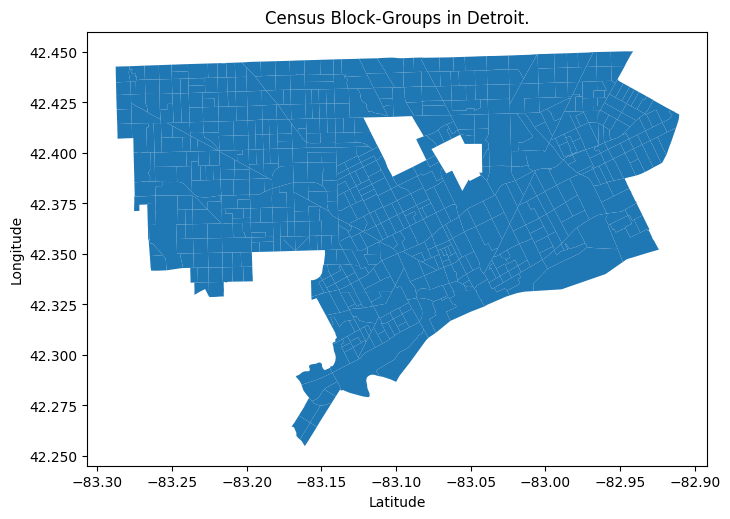

In [8]:
#Plotting a map of blockgroups in Detroit.
fig, ax = plt.subplots(figsize=(8,8))
gdf.plot(ax=ax)
plt.title("Census Block-Groups in Detroit.")
plt.xlabel("Latitude")
plt.ylabel("Longitude")

### Superblocks

As per our parameter of serving all populations of the City of Detroit, we first set out to group areas of the city together to create locations for stops. We decide to use population as our parameter. To create these areas, we group together adjacent block groups to create larger geographical and population areas, what we refer to as "superblocks". Each of these superblocks will have one train stop assigned to it and will by extension have one line running through it.

In [10]:
def find_adjacent_blocks(block, gdf):
    """
    Finds blocks adjacent to the given block.
    
    Parameters:
    - block: The GeoDataFrame row of the current block.
    - gdf: The entire GeoDataFrame of blocks.
    
    Returns:
    - A GeoDataFrame of adjacent blocks.
    """
    # Use the touches method to find blocks that share a boundary with the current block
    adjacent = gdf[gdf.geometry.touches(block.geometry)]
    return adjacent

def group_blocks(gdf, target_population, margin=1000):
    """
    
    Groups blocks into supergroups based on adjacency and population criteria.
    
    Parameters:
    - gdf: GeoDataFrame containing all blocks with their population.
    - target_population: The target population for each group.
    - margin: The margin of error for the target population.
    
    Returns:
    - A list of GeoDataFrames, each representing a grouped superblock.
    """
    grouped_blocks = []
    visited = set()
    
    for index, block in gdf.iterrows():
        if index in visited:
            continue
        
        current_group = [block]
        current_population = block['VALUE9']
        queue = [block]
        visited.add(index)
        
        while queue:
            current_block = queue.pop(0)
            if current_population >= target_population - margin and current_population <= target_population + margin:
                break
            
            adjacents = find_adjacent_blocks(current_block, gdf)
            
            for _, adj_block in adjacents.iterrows():
                adj_index = adj_block.name
                if adj_index not in visited and current_population + adj_block['VALUE9'] <= target_population + margin:
                    visited.add(adj_index)
                    current_group.append(adj_block)
                    current_population += adj_block['VALUE9']
                    queue.append(adj_block)
        
        if current_group:
            grouped_blocks.append(gpd.GeoDataFrame(current_group))
    
    return grouped_blocks

In [22]:
#Call group_blocks function
target_population = 19000
margin = 2000
supergroups = group_blocks(gdf, target_population, margin)
len(supergroups)

42

/tmp/ipykernel_543097/2362820943.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(supergroups))


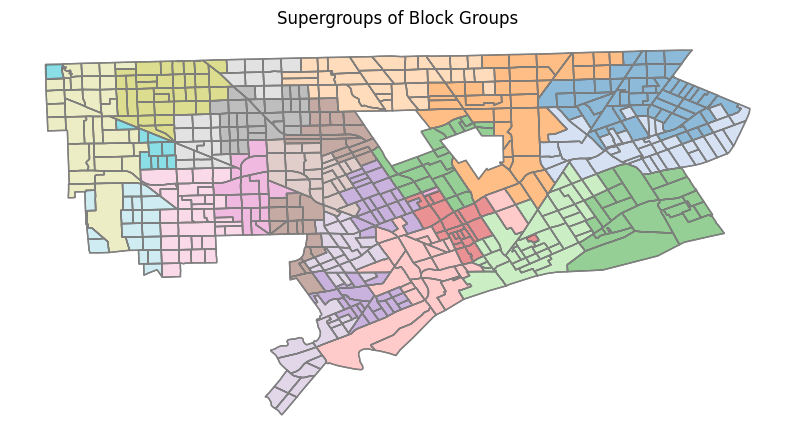

In [23]:
# Set up the plot
fig, ax = plt.subplots(figsize=(10, 10))
gdf.boundary.plot(ax=ax, linewidth=1, color='gray')
colors = plt.cm.get_cmap('tab20', len(supergroups)) 
for i, group in enumerate(supergroups):
    group.plot(ax=ax, color=colors(i), edgecolor='black', alpha=0.5)
ax.set_title('Supergroups of Block Groups')
ax.set_axis_off()  

plt.show()